In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from utils import chamfer_loss
from utils import hungarian_loss
from fspool import FSPool
from model import FSEncoder
from dspn import *
from model import FSEncoderClasification
from MnistSet import MNISTSet
from MnistSet import get_loader

In [2]:
train_loader = get_loader(
            MNISTSet(train=True, full=True), batch_size=1, num_workers=2
        )

In [3]:
test_loader = get_loader(
            MNISTSet(train=False, full=True), batch_size=1, num_workers=2
        )

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torchvision
import matplotlib.pyplot as plt
import numpy as np



def build_net():
    set_channels = 2
    set_size = 342
    hidden_dim = 256
    inner_lr = 800
    iters = 10
    latent_dim = 64
    input_encoder = None

    set_encoder = FSEncoder(set_channels, latent_dim, hidden_dim)
    set_decoder = DSPN(set_encoder, set_channels, set_size, hidden_dim, iters, inner_lr)
    net = Net(
        input_encoder=input_encoder, set_encoder=set_encoder, set_decoder=set_decoder
    )
    return net


class Net(nn.Module):
    def __init__(self, set_encoder, set_decoder, input_encoder=None):
        """
        In the auto-encoder setting, don't pass an input_encoder because the target set and mask is
        assumed to be the input.
        In the general prediction setting, must pass all three.
        """
        super().__init__()
        self.set_encoder = set_encoder
        self.input_encoder = input_encoder
        self.set_decoder = set_decoder

        for m in self.modules():
            if (
                isinstance(m, nn.Linear)
                or isinstance(m, nn.Conv2d)
                or isinstance(m, nn.Conv1d)
            ):
                init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    m.bias.data.zero_()

    def forward(self, input, target_set, target_mask):
        if self.input_encoder is None:
            # auto-encoder, ignore input and use target set and mask as input instead
            latent_repr = self.set_encoder(target_set, target_mask)
            target_repr = latent_repr
        else:
            # set prediction, use proper input_encoder
            latent_repr = self.input_encoder(input)
            # note that target repr is only used for loss computation in training
            # during inference, knowledge about the target is not needed
            target_repr = self.set_encoder(target_set, target_mask)

        predicted_set = self.set_decoder(latent_repr)

        return predicted_set, (target_repr, latent_repr)

In [5]:
net = build_net()

In [6]:
net

Net(
  (set_encoder): FSEncoder(
    (conv): Sequential(
      (0): Conv1d(3, 256, kernel_size=(1,), stride=(1,))
      (1): ReLU()
      (2): Conv1d(256, 256, kernel_size=(1,), stride=(1,))
      (3): ReLU()
      (4): Conv1d(256, 64, kernel_size=(1,), stride=(1,))
    )
    (pool): FSPool()
  )
  (set_decoder): DSPN(
    (encoder): FSEncoder(
      (conv): Sequential(
        (0): Conv1d(3, 256, kernel_size=(1,), stride=(1,))
        (1): ReLU()
        (2): Conv1d(256, 256, kernel_size=(1,), stride=(1,))
        (3): ReLU()
        (4): Conv1d(256, 64, kernel_size=(1,), stride=(1,))
      )
      (pool): FSPool()
    )
  )
)

In [7]:
optimizer = torch.optim.Adam(
    [p for p in net.parameters() if p.requires_grad], lr=0.01
)

In [9]:
import seaborn as sn
import matplotlib
import matplotlib.pyplot as pyplot
import numpy as np

### Usando chamfer loss

torch.Size([2, 342])


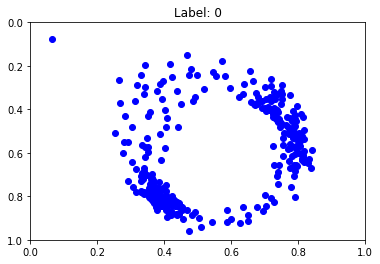

torch.Size([2, 342])


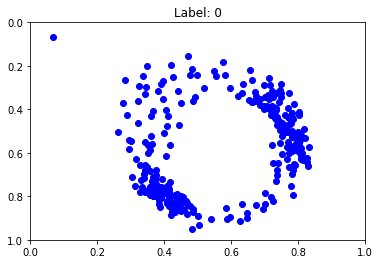

torch.Size([2, 342])


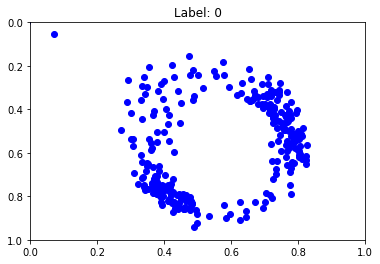

torch.Size([2, 342])


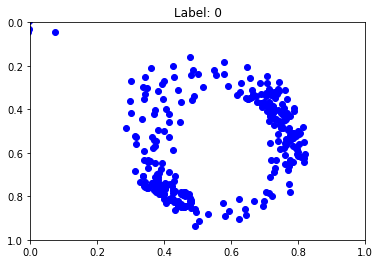

torch.Size([2, 342])


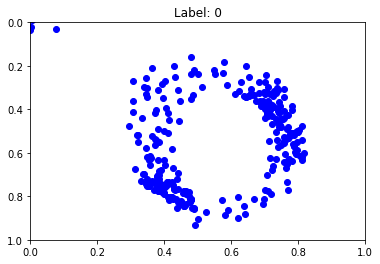

torch.Size([2, 342])


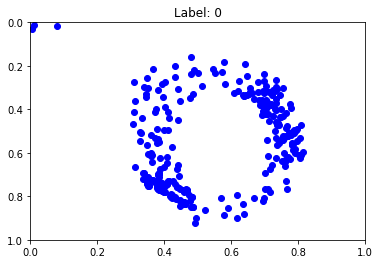

torch.Size([2, 342])


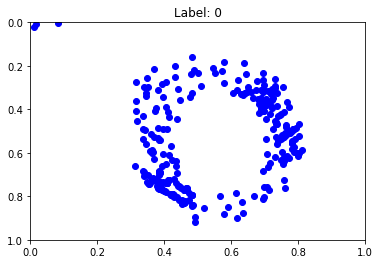

torch.Size([2, 342])


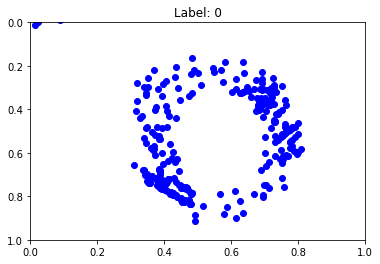

torch.Size([2, 342])


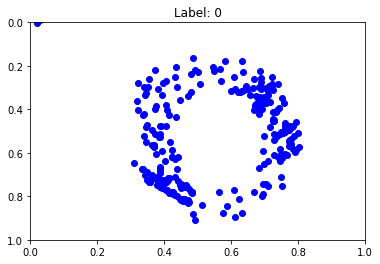

torch.Size([2, 342])


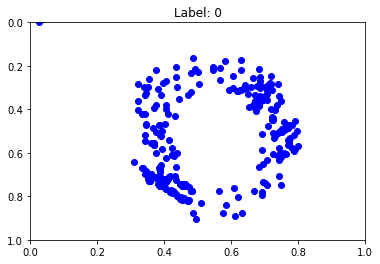

torch.Size([2, 342])


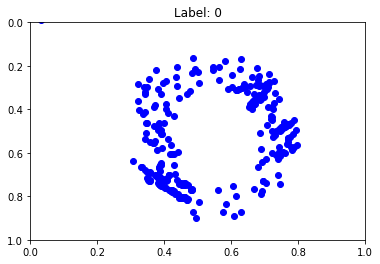

tensor([0.0004, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003,
        0.0003, 0.0004], grad_fn=<MeanBackward1>)
tensor([0])
tensor([0.0005, 0.0005, 0.0004, 0.0004, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003,
        0.0003, 0.0004], grad_fn=<MeanBackward1>)
tensor([0.0005, 0.0004, 0.0003, 0.0003, 0.0002, 0.0003, 0.0002, 0.0003, 0.0003,
        0.0003, 0.0003], grad_fn=<MeanBackward1>)
tensor([0.0005, 0.0002, 0.0002, 0.0003, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002,
        0.0003, 0.0003], grad_fn=<MeanBackward1>)
tensor([0.0004, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0003, 0.0004,
        0.0004, 0.0005], grad_fn=<MeanBackward1>)
tensor([0.0004, 0.0003, 0.0002, 0.0002, 0.0003, 0.0003, 0.0003, 0.0002, 0.0002,
        0.0002, 0.0002], grad_fn=<MeanBackward1>)
tensor([0.0004, 0.0003, 0.0003, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002,
        0.0002, 0.0003], grad_fn=<MeanBackward1>)
tensor([0.0004, 0.0003, 0.0003, 0.0003, 0.0003, 0.0002, 0.0002, 0.0002, 0.0002

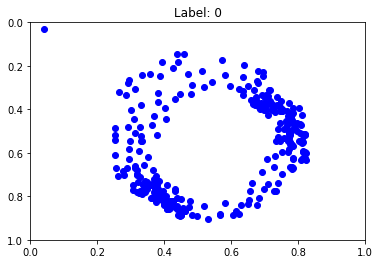

torch.Size([2, 342])


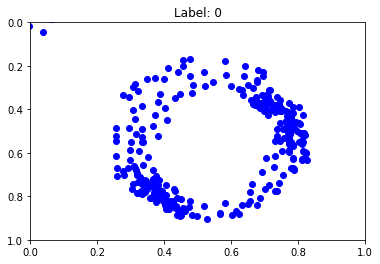

torch.Size([2, 342])


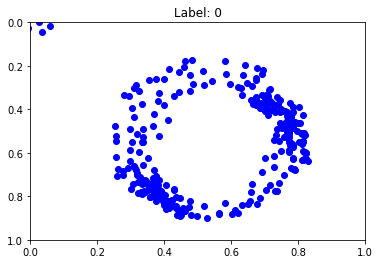

torch.Size([2, 342])


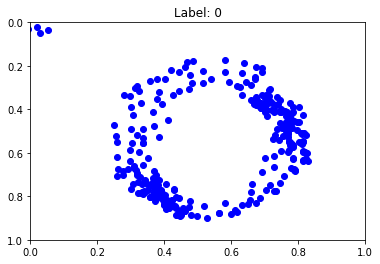

torch.Size([2, 342])


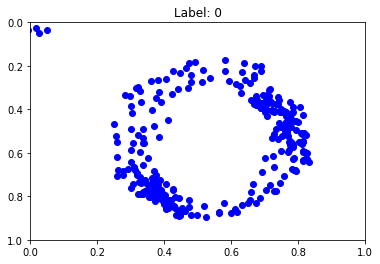

torch.Size([2, 342])


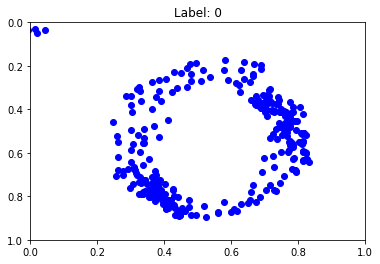

torch.Size([2, 342])


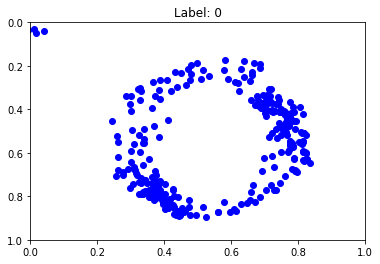

torch.Size([2, 342])


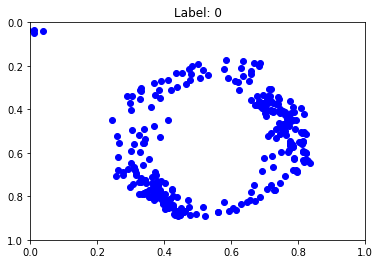

torch.Size([2, 342])


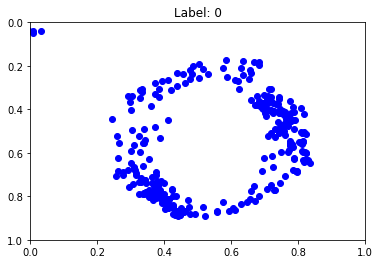

torch.Size([2, 342])


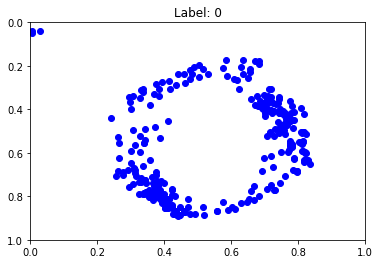

torch.Size([2, 342])


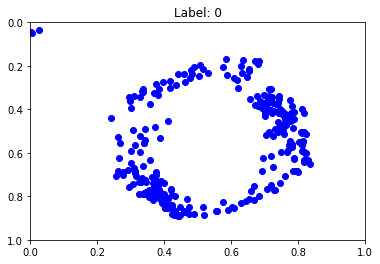

tensor([0.0003, 0.0002, 0.0002, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003,
        0.0003, 0.0003], grad_fn=<MeanBackward1>)
tensor([0.0003, 0.0002, 0.0002, 0.0002, 0.0003, 0.0003, 0.0003, 0.0004, 0.0004,
        0.0004, 0.0005], grad_fn=<MeanBackward1>)
tensor([0.0004, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002,
        0.0002, 0.0002], grad_fn=<MeanBackward1>)
tensor([0.0004, 0.0003, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002,
        0.0002, 0.0002], grad_fn=<MeanBackward1>)
tensor([0.0004, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002,
        0.0002, 0.0002], grad_fn=<MeanBackward1>)
tensor([0.0003, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002,
        0.0002, 0.0002], grad_fn=<MeanBackward1>)
tensor([0.0003, 0.0002, 0.0001, 0.0001, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002,
        0.0002, 0.0002], grad_fn=<MeanBackward1>)
tensor([0.0002, 0.0002, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001,
        0.

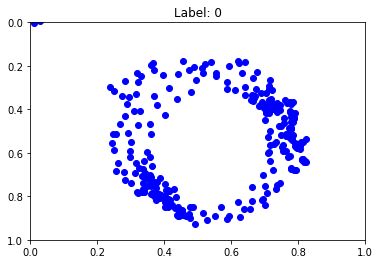

torch.Size([2, 342])


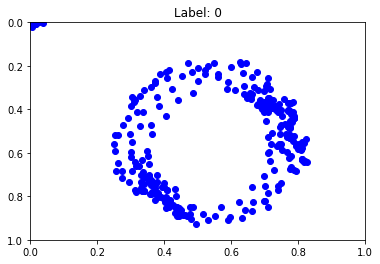

torch.Size([2, 342])


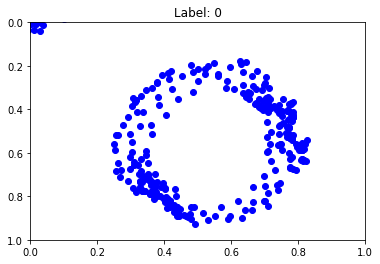

torch.Size([2, 342])


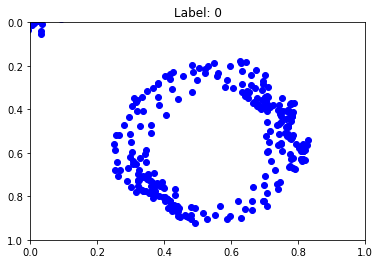

torch.Size([2, 342])


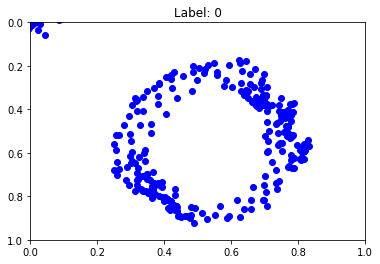

torch.Size([2, 342])


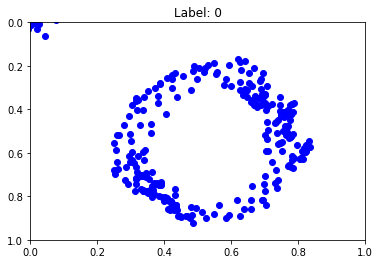

torch.Size([2, 342])


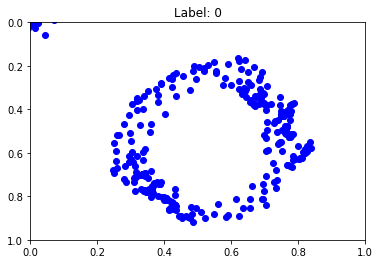

torch.Size([2, 342])


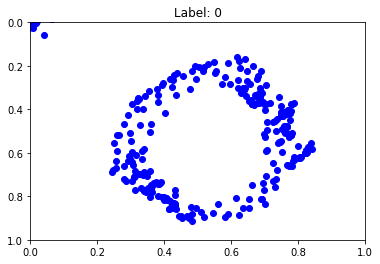

torch.Size([2, 342])


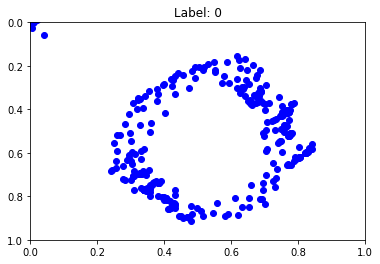

torch.Size([2, 342])


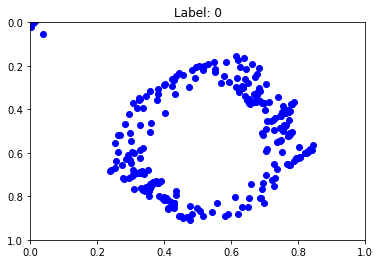

torch.Size([2, 342])


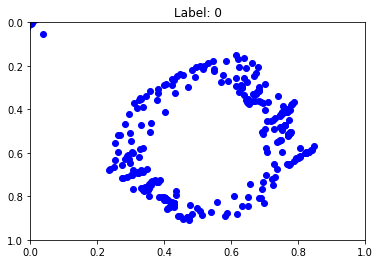

tensor([2.0894e-04, 1.0661e-04, 1.0090e-04, 9.9256e-05, 9.1311e-05, 8.1155e-05,
        8.1297e-05, 7.8515e-05, 8.0492e-05, 8.2917e-05, 8.5286e-05],
       grad_fn=<MeanBackward1>)
tensor([2.0290e-04, 1.0622e-04, 8.8094e-05, 8.2026e-05, 7.6304e-05, 7.5227e-05,
        7.4178e-05, 7.7493e-05, 8.0006e-05, 8.9800e-05, 9.3308e-05],
       grad_fn=<MeanBackward1>)
tensor([1.9845e-04, 1.0921e-04, 9.1967e-05, 8.4132e-05, 8.3147e-05, 7.9729e-05,
        8.3946e-05, 8.2816e-05, 9.1629e-05, 9.9087e-05, 1.0578e-04],
       grad_fn=<MeanBackward1>)
tensor([1.9527e-04, 1.0632e-04, 8.6220e-05, 8.0199e-05, 7.2793e-05, 7.0064e-05,
        6.8647e-05, 7.0572e-05, 7.1942e-05, 7.4692e-05, 7.8929e-05],
       grad_fn=<MeanBackward1>)
tensor([1.9246e-04, 1.0106e-04, 9.3953e-05, 9.6714e-05, 8.2584e-05, 9.1135e-05,
        7.5057e-05, 8.0876e-05, 7.6090e-05, 7.6022e-05, 7.9705e-05],
       grad_fn=<MeanBackward1>)
tensor([1.8968e-04, 1.0407e-04, 8.8690e-05, 8.8808e-05, 7.8280e-05, 7.4619e-05,
        7.0389e

tensor([1.4927e-04, 8.2592e-05, 7.6847e-05, 5.7984e-05, 4.0666e-05, 3.8924e-05,
        3.7342e-05, 3.4171e-05, 3.6067e-05, 3.9569e-05, 3.7970e-05],
       grad_fn=<MeanBackward1>)
tensor([1.4727e-04, 1.1550e-04, 6.8798e-05, 5.3604e-05, 3.9574e-05, 3.5464e-05,
        3.7455e-05, 3.4863e-05, 3.9926e-05, 4.3645e-05, 3.7943e-05],
       grad_fn=<MeanBackward1>)
tensor([1.4508e-04, 1.0556e-04, 6.3345e-05, 6.0180e-05, 3.7560e-05, 4.5117e-05,
        4.2641e-05, 4.2183e-05, 4.1813e-05, 4.2714e-05, 4.3183e-05],
       grad_fn=<MeanBackward1>)
torch.Size([2, 342])


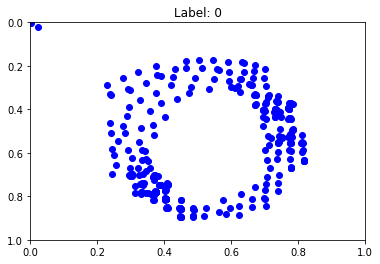

torch.Size([2, 342])


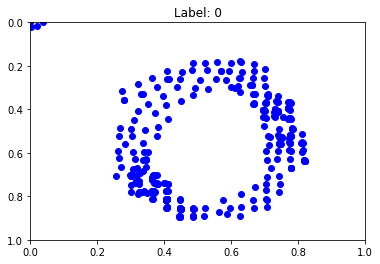

torch.Size([2, 342])


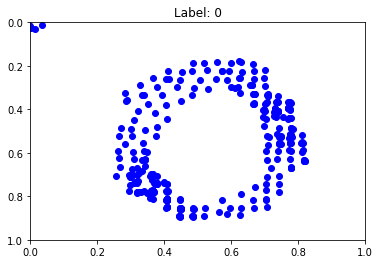

torch.Size([2, 342])


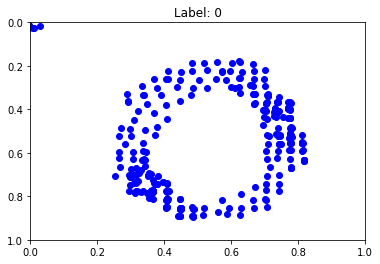

torch.Size([2, 342])


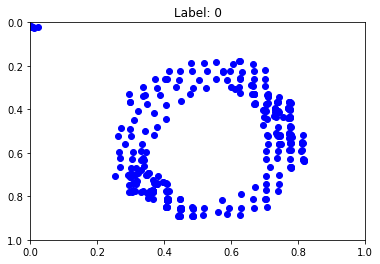

torch.Size([2, 342])


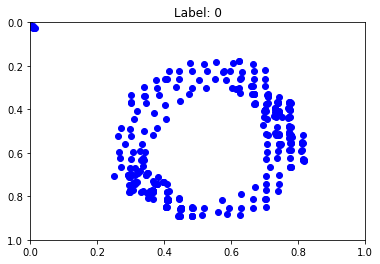

torch.Size([2, 342])


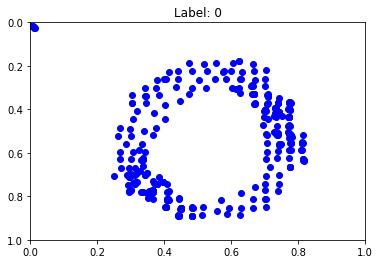

torch.Size([2, 342])


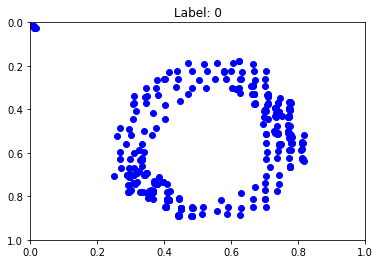

torch.Size([2, 342])


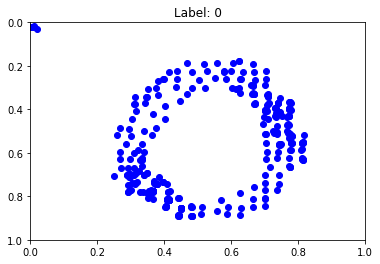

torch.Size([2, 342])


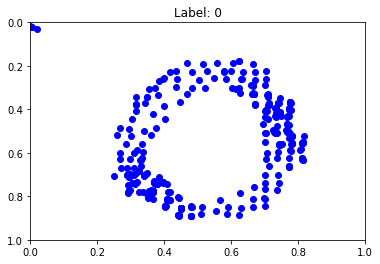

torch.Size([2, 342])


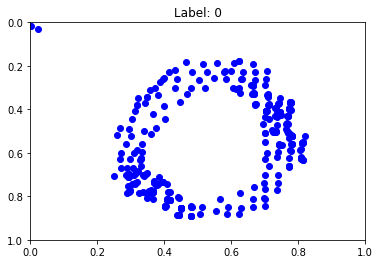

tensor([1.4288e-04, 1.0598e-04, 7.5828e-05, 6.8415e-05, 6.0203e-05, 3.7734e-05,
        4.6745e-05, 5.4120e-05, 6.4329e-05, 6.4141e-05, 6.7475e-05],
       grad_fn=<MeanBackward1>)


In [25]:
for i in range(100):
    input, target_set, target_mask = expected,sample,mask_sample
    if(i == 1):
        print(input)
    (progress, masks, evals, gradn), (y_enc, y_label) = net(input, target_set, target_mask)
    if i == 0 or  i == 25 or i ==  50 or i == 99:
    #plt.grid(False)
    #plt.tight_layout()
    #print(len(progress))
        for  a in progress:
            sam = a[0].detach().numpy()
            x = sam[1, :]
            y = sam[0, :]
            pyplot.scatter(x, y,color ='b')
            #plt.axes().set_aspect("equal")
            plt.axis([0, 1, 1, 0])
            plt.title('Label: {}'.format(input[0]))
            #plt.savefig('test.png')
            plt.show()
            progress_only = progress

  # if using mask as feature, concat mask feature into progress
    target_set = torch.cat(
      [target_set, target_mask.unsqueeze(dim=1)], dim=1)
    progress = [
      torch.cat([p, m.unsqueeze(dim=1)], dim=1)
      for p, m in zip(progress, masks)
            ]
  # dim 0 is over the inner iteration steps
  # target set is broadcasted over dim 0
    set_loss = chamfer_loss(
      torch.stack(progress), target_set.unsqueeze(0)
    )
    loss = set_loss.mean()
    print(set_loss)
    #print(loss)
    progress = progress_only

    #print("New progress",len(progress))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


In [31]:
#with torch.no_grad():
(progress, masks, evals, gradn), (y_enc, y_label) = net(input,sample,mask_sample)

In [37]:
progress[0].shape
sam = progress[1].squeeze(0).detach().numpy()

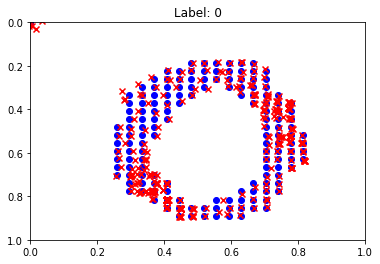

torch.Tensor

In [39]:
dataset = MNISTSet(train=False, full=True)
expected, sample,mask_sample = dataset[13]
x = sample[1, :]
y = sample[0, :]
pyplot.scatter(x, y,color ='b')

x = sam[1, :]
y = sam[0, :]
pyplot.scatter(x, y,marker = 'x',color ='r')

pyplot.axis([0, 1, 1, 0])
pyplot.title('Label: {}'.format(expected))
#plt.savefig('test.png')
pyplot.show()
sample = sample.unsqueeze(0)
mask_sample = mask_sample.unsqueeze(0)
expected = torch.tensor(expected).unsqueeze(0)
type(sample)

### Usando Hungarian

In [41]:
netHungarian = build_net()
optimizer = torch.optim.Adam(
    [p for p in netHungarian.parameters() if p.requires_grad], lr=0.01
)

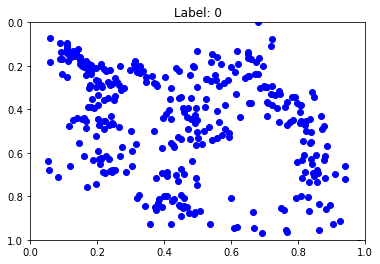

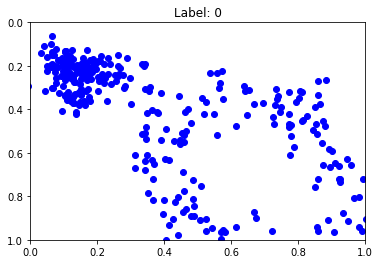

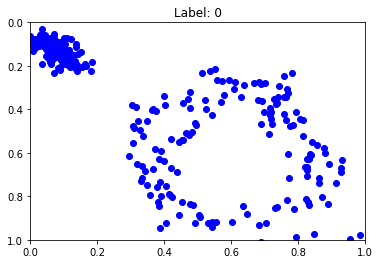

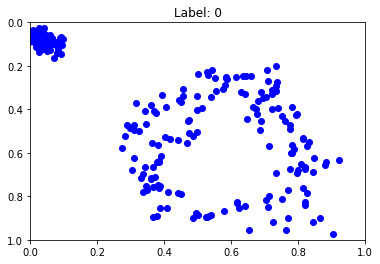

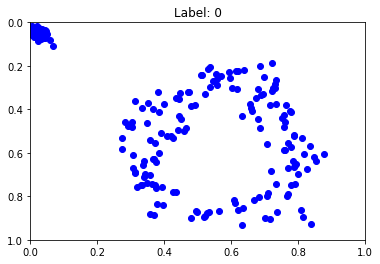

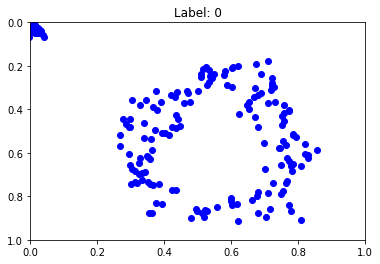

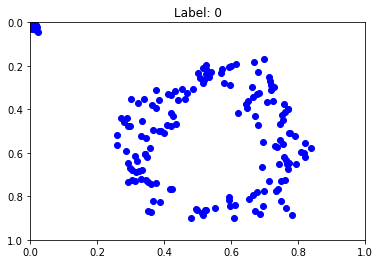

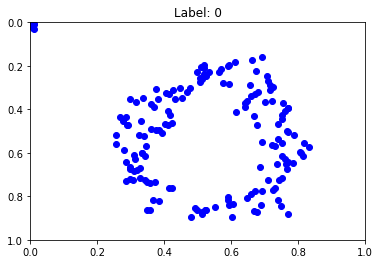

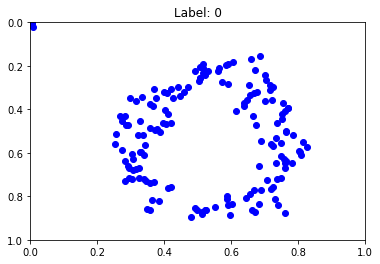

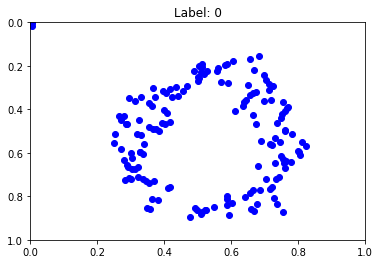

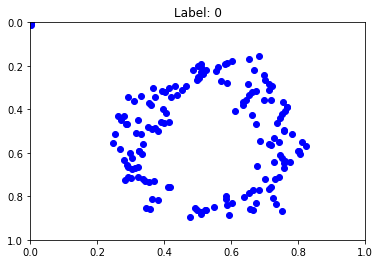

tensor(0.0002, grad_fn=<MeanBackward0>)
tensor([0])
tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(0.0001, grad_fn=<MeanBackward0>)
tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(0.0003, grad_fn=<MeanBackward0>)
tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(0.0003, grad_fn=<MeanBackward0>)
tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(0.0001, grad_fn=<MeanBackward0>)
tensor(0.0001, grad_fn=<MeanBackward0>)
tensor(0.0001, grad_fn=<MeanBackward0>)
tensor(0.0001, grad_fn=<MeanBackward0>)
tensor(0.0001, grad_fn=<MeanBackward0>)
tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(0.0001, grad_fn=<MeanBackward0>)
tensor(0.0001, grad_fn=<MeanBackward0>)
tensor(0.0001, grad_fn=<MeanBackward0>)
tensor(0.0001, grad_fn=<MeanBackward0>)
tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(0.0002, grad_fn=<Mean

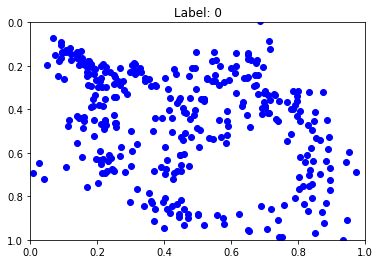

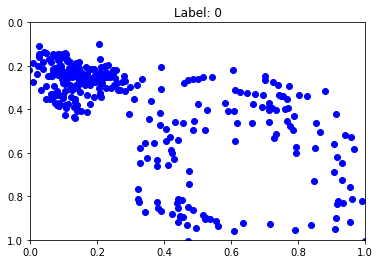

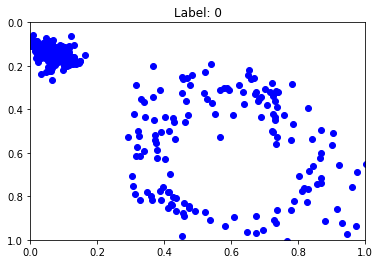

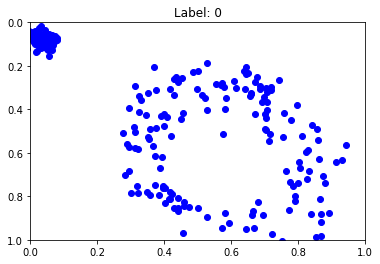

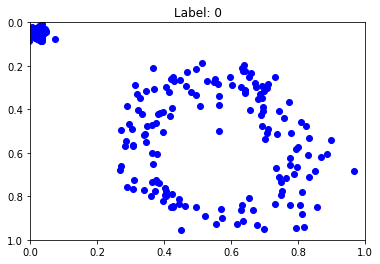

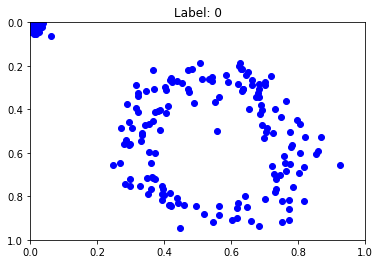

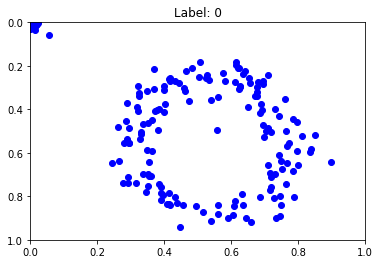

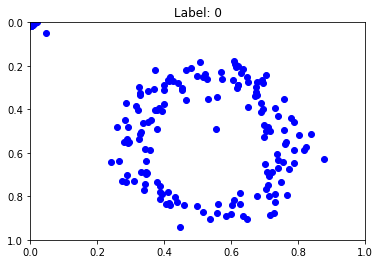

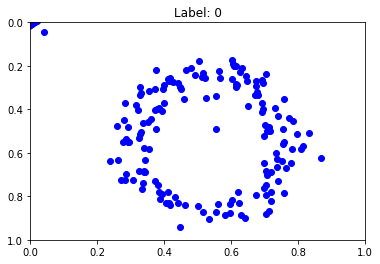

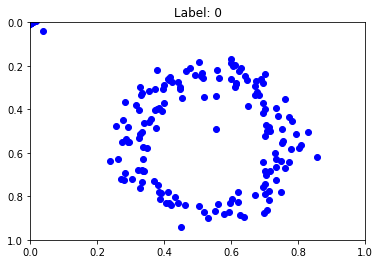

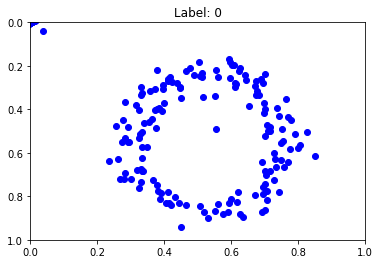

tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(0.0001, grad_fn=<MeanBackward0>)
tensor(0.0001, grad_fn=<MeanBackward0>)
tensor(0.0001, grad_fn=<MeanBackward0>)
tensor(0.0001, grad_fn=<MeanBackward0>)
tensor(0.0001, grad_fn=<MeanBackward0>)
tensor(0.0001, grad_fn=<MeanBackward0>)
tensor(0.0001, grad_fn=<MeanBackward0>)
tensor(0.0001, grad_fn=<MeanBackward0>)
tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(0.0003, grad_fn=<MeanBackward0>)
tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(0.0003, grad_fn=<MeanBackward0>)


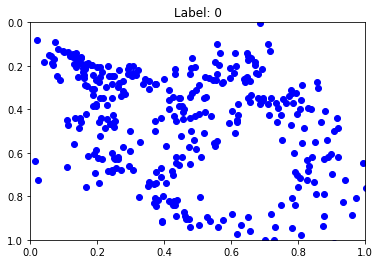

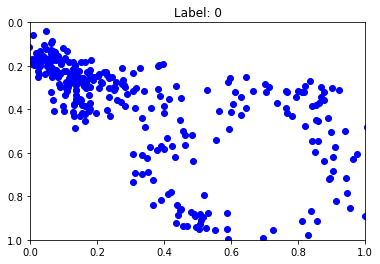

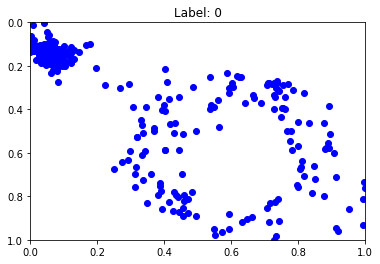

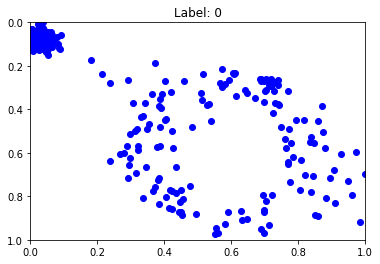

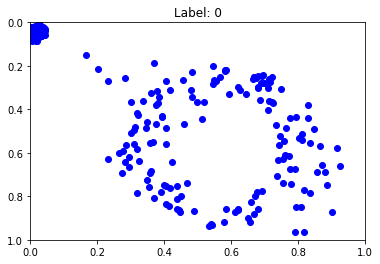

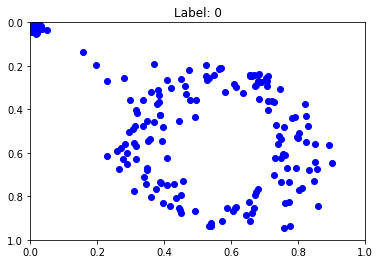

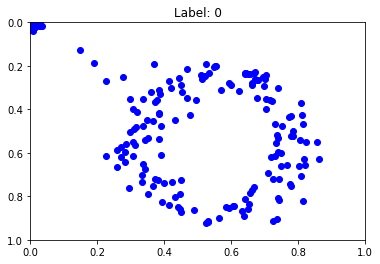

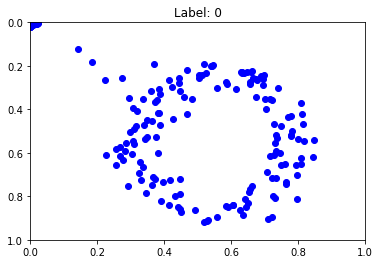

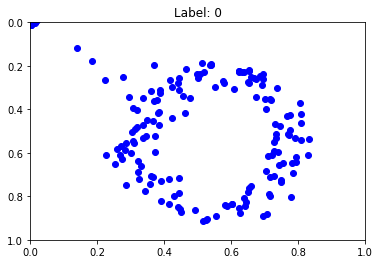

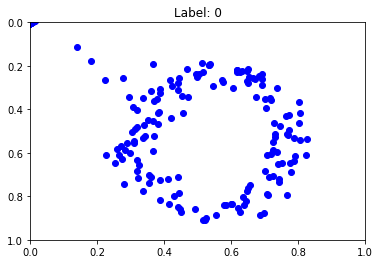

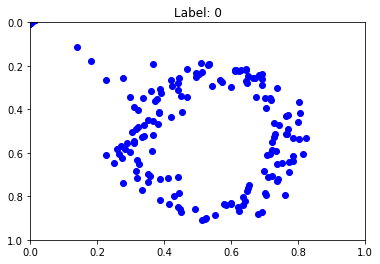

tensor(0.0003, grad_fn=<MeanBackward0>)
tensor(0.0005, grad_fn=<MeanBackward0>)
tensor(0.0001, grad_fn=<MeanBackward0>)
tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(0.0005, grad_fn=<MeanBackward0>)
tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(0.0003, grad_fn=<MeanBackward0>)
tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(0.0001, grad_fn=<MeanBackward0>)
tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(0.0001, grad_fn=<MeanBackward0>)
tensor(0.0001, grad_fn=<MeanBackward0>)
tensor(0.0001, grad_fn=<MeanBackward0>)
tensor(0.0001, grad_fn=<MeanBackward0>)
tensor(0.0001, grad_fn=<MeanBackward0>)
tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(0.0001, grad_fn=<MeanBackward0>)
tensor(0.0001, grad_fn=<MeanBackward0>)
tensor(0.0001, grad_fn=<MeanBackward0>)


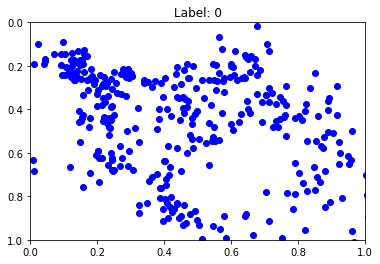

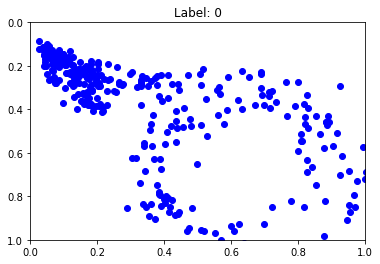

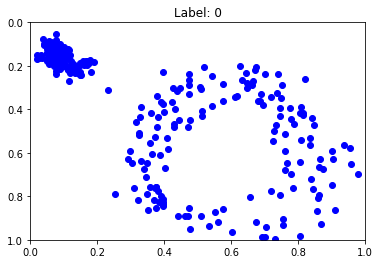

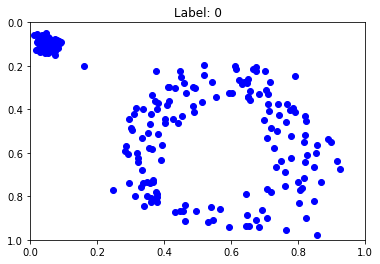

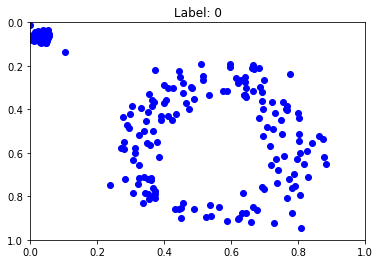

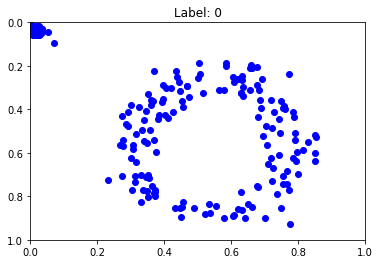

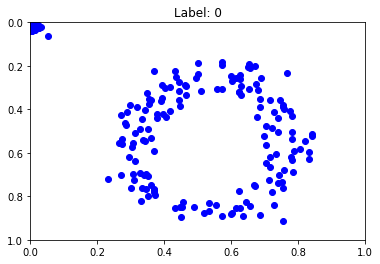

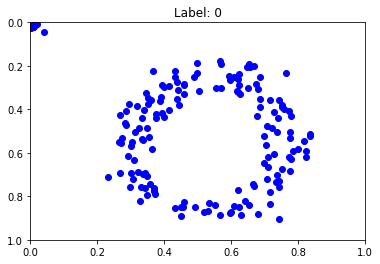

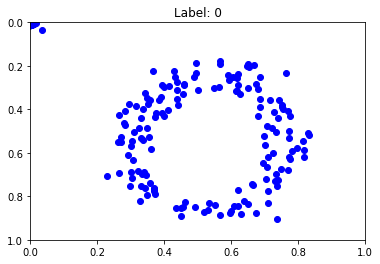

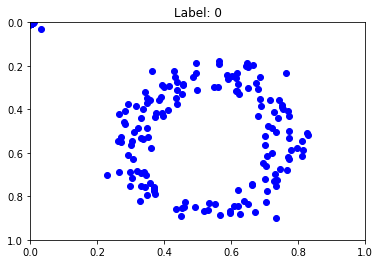

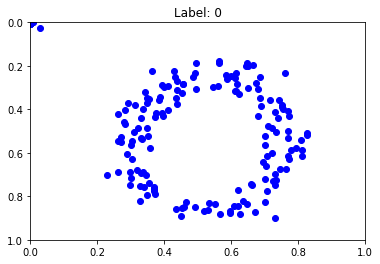

tensor(9.6770e-05, grad_fn=<MeanBackward0>)


In [44]:
for i in range(100):
    #input, target_set, target_mask = map(lambda x: x, sample)
    if(i == 1):
        print(input)
    input, target_set, target_mask = expected,sample,mask_sample
    (progress, masks, evals, gradn), (y_enc, y_label) = netHungarian(input, target_set, target_mask)
    if i == 0 or  i == 25 or i ==  50 or i == 99:
    #plt.grid(False)
    #plt.tight_layout()
    #print(len(progress))
        for  a in progress:
          #print(a.shape)
            #a = a.cpu().data.numpy()
            sam = a[0].detach().numpy()
            x = sam[1, :]
            y = sam[0, :]
            pyplot.scatter(x, y,color ='b')
            plt.axis([0, 1, 1, 0])
            plt.title('Label: {}'.format(input[0]))
            #plt.savefig('test.png')
            plt.show()
            progress_only = progress

  # if using mask as feature, concat mask feature into progress
    target_set = torch.cat(
      [target_set, target_mask.unsqueeze(dim=1)], dim=1)
    progress = [
      torch.cat([p, m.unsqueeze(dim=1)], dim=1)
      for p, m in zip(progress, masks)
            ]
  # dim 0 is over the inner iteration steps
  # target set is broadcasted over dim 0
    a = torch.stack(progress)
  # target set is explicitly broadcasted over dim 0
    b = target_set.repeat(a.size(0), 1, 1, 1)
  # flatten inner iteration dim and batch dim
    a = a.view(-1, a.size(2), a.size(3))
    b = b.view(-1, b.size(2), b.size(3))
    set_loss = hungarian_loss(
      progress[-1], target_set
    ).unsqueeze(0)
    loss = set_loss.mean()
    #print(set_loss)
    print(loss)
    progress = progress_only

    #print("New progress",len(progress))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


In [45]:
#with torch.no_grad():
(progress, masks, evals, gradn), (y_enc, y_label) = netHungarian(input,sample,mask_sample)

In [48]:
progress[0].shape
sam = progress[10].squeeze(0).detach().numpy()

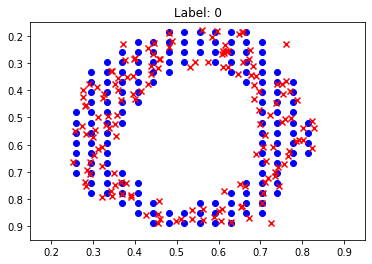

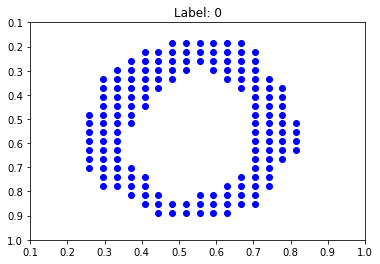

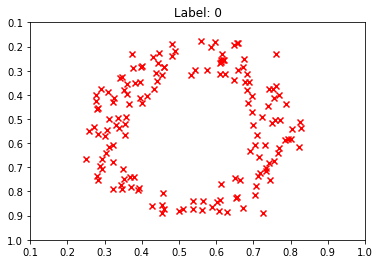

torch.Tensor

In [58]:
dataset = MNISTSet(train=False, full=True)
expected, sample,mask_sample = dataset[13]
x = sample[1, :]
y = sample[0, :]
pyplot.scatter(x, y,color ='b')

x = sam[1, :]
y = sam[0, :]
pyplot.scatter(x, y,marker = 'x',color ='r')

pyplot.axis([0.15, 0.95, 0.95, 0.15])
pyplot.title('Label: {}'.format(expected))
#plt.savefig('test.png')
pyplot.show()

x = sample[1, :]
y = sample[0, :]
pyplot.scatter(x, y,color ='b')
pyplot.axis([0.1, 1, 1, 0.1])
pyplot.title('Label: {}'.format(expected))

pyplot.show()
x = sam[1, :]
y = sam[0, :]
pyplot.scatter(x, y,marker = 'x',color ='r')
pyplot.axis([0.1, 1, 1, 0.1])
pyplot.title('Label: {}'.format(expected))
#plt.savefig('test.png')
pyplot.show()

sample = sample.unsqueeze(0)
mask_sample = mask_sample.unsqueeze(0)
expected = torch.tensor(expected).unsqueeze(0)
type(sample)